In [43]:
#IGNORE THIS!!!!! IT'S JUST PREPROCESSING OF DATA 
#I just want to keep it for our submission


#from dblplib import parse, parse_file
import dblplib
# from dblplib import parse_file
from lxml import etree
from datetime import datetime
import csv
import ujson
import codecs
import re
from github_com.kennethreitz import requests
assert requests.get('https://github.com/IsaacChanghau/DBLPParser').status_code == 200


# all of the element types in dblp
all_elements = {"article", "inproceedings", "proceedings", "book", "incollection", "phdthesis", "mastersthesis", "www"}
# all of the feature types in dblp
all_features = {"address", "author", "booktitle", "cdrom", "chapter", "cite", "crossref", "editor", "ee", "isbn",
                "journal", "month", "note", "number", "pages", "publisher", "school", "series", "title", "url",
                "volume", "year"}


def log_msg(message):
    """Produce a log with current time"""
    print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), message)


def context_iter(dblp_path):
    """Create a dblp data iterator of (event, element) pairs for processing"""
    return etree.iterparse(source=dblp_path, dtd_validation=True, load_dtd=True)  # required dtd


def clear_element(element):
    """Free up memory for temporary element tree after processing the element"""
    element.clear()
    while element.getprevious() is not None:
        del element.getparent()[0]


def count_pages(pages):
    """Borrowed from: https://github.com/billjh/dblp-iter-parser/blob/master/iter_parser.py
    Parse pages string and count number of pages. There might be multiple pages separated by commas.
    VALID FORMATS:
        51         -> Single number
        23-43      -> Range by two numbers
    NON-DIGITS ARE ALLOWED BUT IGNORED:
        AG83-AG120
        90210H     -> Containing alphabets
        8e:1-8e:4
        11:12-21   -> Containing colons
        P1.35      -> Containing dots
        S2/109     -> Containing slashes
        2-3&4      -> Containing ampersands and more...
    INVALID FORMATS:
        I-XXI      -> Roman numerals are not recognized
        0-         -> Incomplete range
        91A-91A-3  -> More than one dash
        f          -> No digits
    ALGORITHM:
        1) Split the string by comma evaluated each part with (2).
        2) Split the part to subparts by dash. If more than two subparts, evaluate to zero. If have two subparts,
           evaluate by (3). If have one subpart, evaluate by (4).
        3) For both subparts, convert to number by (4). If not successful in either subpart, return zero. Subtract first
           to second, if negative, return zero; else return (second - first + 1) as page count.
        4) Search for number consist of digits. Only take the last one (P17.23 -> 23). Return page count as 1 for (2)
           if find; 0 for (2) if not find. Return the number for (3) if find; -1 for (3) if not find.
    """
    cnt = 0
    for part in re.compile(r",").split(pages):
        subparts = re.compile(r"-").split(part)
        if len(subparts) > 2:
            continue
        else:
            try:
                re_digits = re.compile(r"[\d]+")
                subparts = [int(re_digits.findall(sub)[-1]) for sub in subparts]
            except IndexError:
                continue
            cnt += 1 if len(subparts) == 1 else subparts[1] - subparts[0] + 1
    return "" if cnt == 0 else str(cnt)


def extract_feature(elem, features, include_key=False):
    """Extract the value of each feature"""
    if include_key:
        attribs = {'key': [elem.attrib['key']]}
    else:
        attribs = {}
    for feature in features:
        attribs[feature] = []
    for sub in elem:
        if sub.tag not in features:
            continue
        if sub.tag == 'title':
            text = re.sub("<.*?>", "", etree.tostring(sub).decode('utf-8')) if sub.text is None else sub.text
        elif sub.tag == 'pages':
            text = count_pages(sub.text)
        else:
            text = sub.text
        if text is not None and len(text) > 0:
            attribs[sub.tag] = attribs.get(sub.tag) + [text]
    return attribs


def parse_all(dblp_path, save_path, include_key=False):
    log_msg("PROCESS: Start parsing...")
    f = open(save_path, 'w', encoding='utf8')
    for _, elem in context_iter(dblp_path):
        if elem.tag in all_elements:
            attrib_values = extract_feature(elem, all_features, include_key)
            f.write(str(attrib_values) + '\n')
        clear_element(elem)
    f.close()
    log_msg("FINISHED...")  # load the saved results line by line using json


def parse_entity(dblp_path, save_path, type_name, features=None, save_to_csv=False, include_key=False):
    """Parse specific elements according to the given type name and features"""
    log_msg("PROCESS: Start parsing for {}...".format(str(type_name)))
    assert features is not None, "features must be assigned before parsing the dblp dataset"
    results = []
    attrib_count, full_entity, part_entity = {}, 0, 0
    for _, elem in context_iter(dblp_path):
        if elem.tag in type_name:
            attrib_values = extract_feature(elem, features, include_key)  # extract required features
            results.append(attrib_values)  # add record to results array
            for key, value in attrib_values.items():
                attrib_count[key] = attrib_count.get(key, 0) + len(value)
            cnt = sum([1 if len(x) > 0 else 0 for x in list(attrib_values.values())])
            if cnt == len(features):
                full_entity += 1
            else:
                part_entity += 1
        elif elem.tag not in all_elements:
            continue
        clear_element(elem)
    if save_to_csv:
        f = open(save_path, 'w', newline='', encoding='utf8')
        writer = csv.writer(f, delimiter=',')
        writer.writerow(features)  # write title
        for record in results:
            # some features contain multiple values (e.g.: author), concatenate with `::`
            row = ['::'.join(v) for v in list(record.values())]
            writer.writerow(row)
        f.close()
    else:  # default save to json file
        with codecs.open(save_path, mode='w', encoding='utf8', errors='ignore') as f:
            ujson.dump(results, f)
    return full_entity, part_entity, attrib_count


def parse_author(dblp_path, save_path, save_to_csv=False):
    type_name = ['article', 'book', 'incollection', 'inproceedings']
    log_msg("PROCESS: Start parsing for {}...".format(str(type_name)))
    authors = set()
    for _, elem in context_iter(dblp_path):
        if elem.tag in type_name:
            authors.update(a.text for a in elem.findall('author'))
        elif elem.tag not in all_elements:
            continue
        clear_element(elem)
    if save_to_csv:
        f = open(save_path, 'w', newline='', encoding='utf8')
        writer = csv.writer(f, delimiter=',')
        writer.writerows([a] for a in sorted(authors))
        f.close()
    else:
        with open(save_path, 'w', encoding='utf8') as f:
            f.write('\n'.join(sorted(authors)))
    log_msg("FINISHED...")


def parse_article(dblp_path, save_path, save_to_csv=False, include_key=False):
    type_name = ['article']
    features = ['title', 'author', 'year', 'journal', 'pages']
    info = parse_entity(dblp_path, save_path, type_name, features, save_to_csv=save_to_csv, include_key=include_key)
    log_msg('Total articles found: {}, articles contain all features: {}, articles contain part of features: {}'
            .format(info[0] + info[1], info[0], info[1]))
    log_msg("Features information: {}".format(str(info[2])))


def parse_inproceedings(dblp_path, save_path, save_to_csv=False, include_key=False):
    type_name = ["inproceedings"]
    features = ['title', 'author', 'year', 'pages', 'booktitle']
    info = parse_entity(dblp_path, save_path, type_name, features, save_to_csv=save_to_csv, include_key=include_key)
    log_msg('Total inproceedings found: {}, inproceedings contain all features: {}, inproceedings contain part of '
            'features: {}'.format(info[0] + info[1], info[0], info[1]))
    log_msg("Features information: {}".format(str(info[2])))


def parse_proceedings(dblp_path, save_path, save_to_csv=False, include_key=False):
    type_name = ["proceedings"]
    features = ['title', 'editor', 'year', 'booktitle', 'series', 'publisher']
    # Other features are 'volume','isbn' and 'url'.
    info = parse_entity(dblp_path, save_path, type_name, features, save_to_csv=save_to_csv, include_key=include_key)
    log_msg('Total proceedings found: {}, proceedings contain all features: {}, proceedings contain part of '
            'features: {}'.format(info[0] + info[1], info[0], info[1]))
    log_msg("Features information: {}".format(str(info[2])))


def parse_book(dblp_path, save_path, save_to_csv=False, include_key=False):
    type_name = ["book"]
    features = ['title', 'author', 'publisher', 'isbn', 'year', 'pages']
    info = parse_entity(dblp_path, save_path, type_name, features, save_to_csv=save_to_csv, include_key=include_key)
    log_msg('Total books found: {}, books contain all features: {}, books contain part of features: {}'
            .format(info[0] + info[1], info[0], info[1]))
    log_msg("Features information: {}".format(str(info[2])))


def parse_publications(dblp_path, save_path, save_to_csv=False, include_key=False):
    type_name = ['article', 'book', 'incollection', 'inproceedings']
    features = ['title', 'year', 'pages']
    info = parse_entity(dblp_path, save_path, type_name, features, save_to_csv=save_to_csv, include_key=include_key)
    log_msg('Total publications found: {}, publications contain all features: {}, publications contain part of '
            'features: {}'.format(info[0] + info[1], info[0], info[1]))
    log_msg("Features information: {}".format(str(info[2])))


dblp_path = '/Users/daniellelarson/cse416/final/dblp-2019-11-01.xml'
save_path = '/Users/daniellelarson/cse416/final/article.json'


In [45]:
%%time
try:
    context_iter(dblp_path)
    log_msg("LOG: Successfully loaded \"{}\".".format(dblp_path))
except IOError:
    log_msg("ERROR: Failed to load file \"{}\". Please check your XML and DTD files.".format(dblp_path))
    exit()
parse_article(dblp_path, save_path, save_to_csv=False)  # default save as json format

2019-12-01 23:46:11 LOG: Successfully loaded "/Users/daniellelarson/cse416/final/dblp-2019-11-01.xml".
2019-12-01 23:46:11 PROCESS: Start parsing for ['article']...
2019-12-01 23:49:00 Total articles found: 2137512, articles contain all features: 1815958, articles contain part of features: 321554
2019-12-01 23:49:00 Features information: {'title': 2137512, 'author': 6264506, 'year': 2137509, 'journal': 2137285, 'pages': 1824941}
CPU times: user 2min 43s, sys: 4.53 s, total: 2min 48s
Wall time: 2min 49s


In [46]:
%%time
save_path = '/Users/daniellelarson/cse416/final/article.csv'
try:
    context_iter(dblp_path)
    log_msg("LOG: Successfully loaded \"{}\".".format(dblp_path))
except IOError:
    log_msg("ERROR: Failed to load file \"{}\". Please check your XML and DTD files.".format(dblp_path))
    exit()
parse_article(dblp_path, save_path, save_to_csv=True)  # default save as json format

2019-12-02 00:04:08 LOG: Successfully loaded "/Users/daniellelarson/cse416/final/dblp-2019-11-01.xml".
2019-12-02 00:04:08 PROCESS: Start parsing for ['article']...
2019-12-02 00:07:00 Total articles found: 2137512, articles contain all features: 1815958, articles contain part of features: 321554
2019-12-02 00:07:00 Features information: {'title': 2137512, 'author': 6264506, 'year': 2137509, 'journal': 2137285, 'pages': 1824941}
CPU times: user 2min 46s, sys: 4.21 s, total: 2min 51s
Wall time: 2min 51s


In [41]:
%%time
#RUN THIS: START HERE TO CREATE GRAPH

#load in from csv (obvs change path)
 
import csv

with open('/Users/daniellelarson/cse416/final/edges_no_title.csv', 'r') as f:
  reader = csv.reader(f)
  edges = list(reader)

CPU times: user 11.6 s, sys: 3.28 s, total: 14.8 s
Wall time: 16.8 s


In [46]:
%%time
#IGNORE THIS 
#It was just to create the original file with the gendered items
 

from genderize import Genderize
import gender_guesser.detector as gender
d = gender.Detector()
genders = []
count = 0
for e in edges:
    name1 = e[0]
    name2 = e[1]
    first1 = name1.split(' ', 1)[0]
    first2 = name2.split(' ', 1)[0]
    #print(first1)
    #print(first2)
    g1 = d.get_gender(first1)
    g2 = d.get_gender(first2)
    #print(g1)
    #print(g2)
    Dict1 = {"name": name1, "gender": g1} 
    Dict2 = {"name": name2, "gender": g2} 
    genders.append([Dict1,Dict2])

CPU times: user 1min 24s, sys: 34 s, total: 1min 58s
Wall time: 2min 18s


In [47]:
#IGNORE THIS 
import json
with open('/Users/daniellelarson/cse416/final/no_title_edges_with_gender', 'w') as fout:
    json.dump(genders, fout)

In [49]:
#IGNORE THIS 
import csv

with open("no_title_edges_with_gender.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(genders)

In [75]:
%%time
#RUN THIS

#create base graph

import networkx as nx
G=nx.Graph()
G.add_edges_from(edges)

CPU times: user 48.6 s, sys: 8min 1s, total: 8min 50s
Wall time: 30min 13s


In [76]:
%%time
#RUN THIS

#assign genders to edges
for e in edges:
    name1 = e[0]
    name2 = e[1]
    first1 = name1.split(' ', 1)[0]
    first2 = name2.split(' ', 1)[0]
    #print(first1)
    #print(first2)
    g1 = d.get_gender(first1)
    g2 = d.get_gender(first2)
    #print(g1)
    #print(g2)
    if (g1 == g2) :
        if(str(g1) == "male"):
            G[name1][name2]['gender'] = 'blue'
        else:
            G[name1][name2]['gender'] = 'pink'
    else:
        G[name1][name2]['gender'] = 'purple'
        
    

CPU times: user 2min 19s, sys: 2min 38s, total: 4min 57s
Wall time: 11min 24s


In [77]:
%%time

#RUN THIS

#label nodes


#G.node[1]['room'] = 714
#assigning genders to nodes
for n in G.nodes():
    first = n.split(' ', 1)[0]
    G.nodes[n]['gender'] = d.get_gender(first)

CPU times: user 14.9 s, sys: 43.9 s, total: 58.8 s
Wall time: 3min 16s


In [78]:
%%time

#RUN THIS



#removing unknown or andy
nodes = []
nodes = G.nodes()
delNodes = []
print(G.number_of_nodes())
for n in nodes:
    if str(G.nodes[n]['gender']) == "andy" :
        delNodes.append(n)
    elif str(G.nodes[n]['gender']) == "unknown":
        delNodes.append(n)
        
G.remove_nodes_from(delNodes)
print(G.number_of_nodes())

1522944
942342
CPU times: user 24.6 s, sys: 8min 7s, total: 8min 32s
Wall time: 27min 22s


CPU times: user 3.85 s, sys: 1min 13s, total: 1min 17s
Wall time: 3min 54s


Text(0, 0.5, 'P(k)')

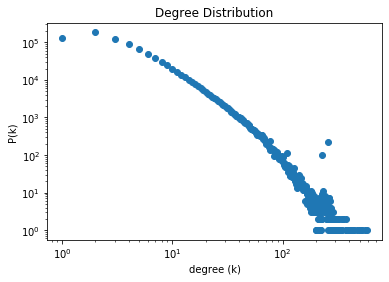

In [83]:
%%time 

import collections as c
import matplotlib.pyplot as plt

nodes = G.nodes()
graph_nodes = {}
for d in G.degree():
    graph_nodes[d[0]] = int(d[1])

k, pk = zip(*c.Counter(graph_nodes.values()).items())

plt.figure(0)
plt.loglog(k,pk, marker = "o", linewidth = 0)
plt.title("Degree Distribution")
plt.xlabel("degree (k)")
plt.ylabel("P(k)")

In [84]:
females = []
males = []
for n in G.nodes():
    if (str(G.nodes[n]['gender']) == "female"):
        females.append(n)
    else:
        males.append(n)

CPU times: user 5.08 s, sys: 21.8 s, total: 26.9 s
Wall time: 1min 9s


Text(0, 0.5, 'P(k)')

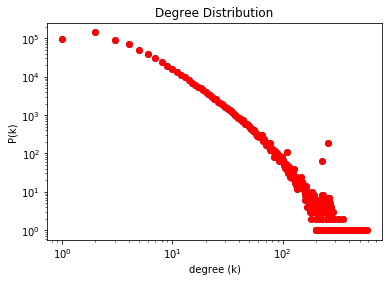

In [87]:
%%time

female_graph_nodes = {}
male_graph_nodes = {}
for d in G.degree():
    if (str(G.nodes[d[0]]['gender']) == "female"):
        female_graph_nodes[d[0]] = int(d[1])
    else:
        male_graph_nodes[d[0]] = int(d[1])


Text(0, 0.5, 'P(k)')

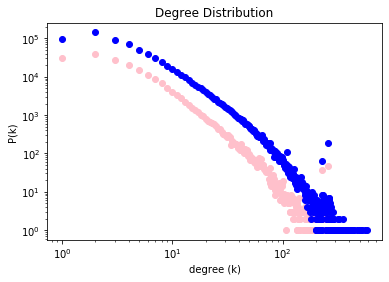

In [90]:
k1, pk1 = zip(*c.Counter(female_graph_nodes.values()).items())
k2, pk2 = zip(*c.Counter(male_graph_nodes.values()).items())

plt.figure(1)
plt.loglog(k1,pk1, marker = "o", linewidth = 0, color ="pink")
plt.loglog(k2,pk2, marker = "o", linewidth = 0, color ="blue")
plt.title("Degree Distribution")
plt.xlabel("degree (k)")
plt.ylabel("P(k)")

In [115]:
%%time
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)
coord = []
print(dmax)
num = G.number_of_nodes()
print(num)

for x in range(dmax):
    y = 0
    for i in female_graph_nodes:
        if (female_graph_nodes[i] >= x):
            y = y + 1
    y = y/num * 100
    coord.append([x,y])

578
942342
CPU times: user 29.6 s, sys: 8.52 s, total: 38.1 s
Wall time: 45.6 s


In [116]:
%%time
coord1 = []
for x1 in range(dmax):
    y1 = 0
    for i in male_graph_nodes:
        if (male_graph_nodes[i] >= x1):
            y1 = y1 + 1
    y1 = y1/num * 100
    coord1.append([x1,y1])

CPU times: user 1min 58s, sys: 1.4 s, total: 1min 59s
Wall time: 2min 1s


Text(0, 0.5, 'Percent')

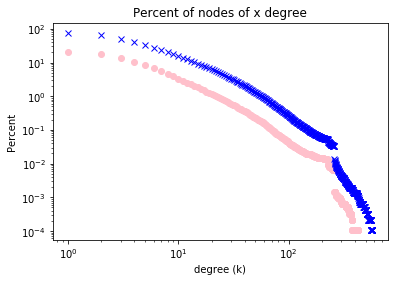

In [117]:
plt.figure(2)
x1 = [x[0] for x in coord]
y1 = [x[1] for x in coord]
x2 = [x1[0] for x1 in coord1]
y2 = [x1[1] for x1 in coord1]
plt.loglog(x1,y1, marker = "o", linewidth = 0, color ="pink")
plt.loglog(x2,y2, marker = "x", linewidth = 0, color ="blue")
plt.title("Percent of nodes of x degree")
plt.xlabel("degree (k)")
plt.ylabel("Percent")

In [118]:
print(len(coord))
print(len(coord1))

578
578


In [119]:
print(dmax)

578


In [134]:
%%time

#start the filtering by keywords

import csv
import sys
csv.field_size_limit(sys.maxsize)
edges_title = []
with open('/Users/daniellelarson/cse416/final/edges_with_title.csv', 'r') as f:
  reader = csv.reader(f)
  edges_title = list(reader)


CPU times: user 52.2 s, sys: 6min 31s, total: 7min 23s
Wall time: 20min 49s


In [189]:
%%time
#filter for AI/ML topics
ml_edges = []
if 'Heterogeneous' in edges_title[5][2]: 
    print('yay')
count = 0
for edge in edges_title:
    try:
        if 'machine learning' in edge[2]: 
            ml_edges.append([edge[0],edge[1]])
        elif 'ai' in edge[2]:
            ml_edges.append([edge[0],edge[1]])
        elif 'artifical intelligence' in edge[2]:
            ml_edges.append([edge[0],edge[1]])
        elif 'deep learning' in edge[2]:
            ml_edges.append([edge[0],edge[1]])
        elif 'neural net' in edge[2]:
            ml_edges.append([edge[0],edge[1]])
    except: 
        #bad entry do nothing
        count = count + 1
print(count)
#filter for systems security (for a smaller graph)
ss_edges = []
count = 0
for edge in edges_title:
    try:
        if 'system security' in edge[2]: 
            ss_edges.append([edge[0],edge[1]])
        elif 'systems security' in edge[2]: 
            ss_edges.append([edge[0],edge[1]])
    except:
        count = count + 1
print(count)

yay
12923
12923
CPU times: user 13 s, sys: 51 s, total: 1min 3s
Wall time: 4min 43s


In [190]:
%%time
#create new graphs
ml=nx.Graph()
ml.add_edges_from(ml_edges)

ss=nx.Graph()
ss.add_edges_from(ss_edges)

CPU times: user 5.74 s, sys: 1min 2s, total: 1min 8s
Wall time: 4min 57s


In [191]:
%%time
#assign genders to node
d = gender.Detector()
for n in ml.nodes():
    first = n.split(' ', 1)[0]
    ml.nodes[n]['gender'] = d.get_gender(first)

for n in ss.nodes():
    first = n.split(' ', 1)[0]
    ss.nodes[n]['gender'] = d.get_gender(first)

CPU times: user 2.93 s, sys: 4.91 s, total: 7.83 s
Wall time: 20.3 s


In [192]:
%%time
#remove badly gendered nodes
nodes = []
nodes = ml.nodes()
delNodes = []
print(ml.number_of_nodes())
for n in nodes:
    if str(ml.nodes[n]['gender']) == "andy" :
        delNodes.append(n)
    elif str(ml.nodes[n]['gender']) == "unknown":
        delNodes.append(n)
        
ml.remove_nodes_from(delNodes)
print(ml.number_of_nodes())


nodes = []
nodes = ss.nodes()
delNodes = []
print(ss.number_of_nodes())
for n in nodes:
    if str(ss.nodes[n]['gender']) == "andy" :
        delNodes.append(n)
    elif str(ss.nodes[n]['gender']) == "unknown":
        delNodes.append(n)
        
ss.remove_nodes_from(delNodes)
print(ss.number_of_nodes())

323195
194299
249
179
CPU times: user 1.97 s, sys: 6.74 s, total: 8.71 s
Wall time: 18.2 s


CPU times: user 758 ms, sys: 1.7 s, total: 2.46 s
Wall time: 3.41 s


Text(0, 0.5, 'P(k)')

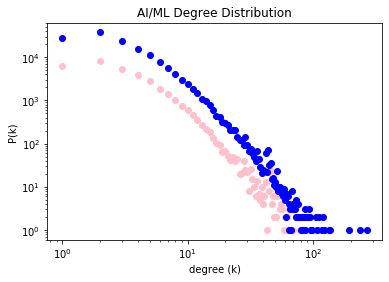

In [193]:
%%time
#for ml graph degree dist

ml_female_graph_nodes = {}
ml_male_graph_nodes = {}
for d in ml.degree():
    if (str(ml.nodes[d[0]]['gender']) == "female"):
        ml_female_graph_nodes[d[0]] = int(d[1])
    else:
        ml_male_graph_nodes[d[0]] = int(d[1])
        
k1, pk1 = zip(*c.Counter(ml_female_graph_nodes.values()).items())
k2, pk2 = zip(*c.Counter(ml_male_graph_nodes.values()).items())

plt.figure(3)
plt.loglog(k1,pk1, marker = "o", linewidth = 0, color ="pink")
plt.loglog(k2,pk2, marker = "o", linewidth = 0, color ="blue")
plt.title("AI/ML Degree Distribution")
plt.xlabel("degree (k)")
plt.ylabel("P(k)")

CPU times: user 15.6 ms, sys: 4.25 ms, total: 19.8 ms
Wall time: 18.9 ms


Text(0, 0.5, 'P(k)')

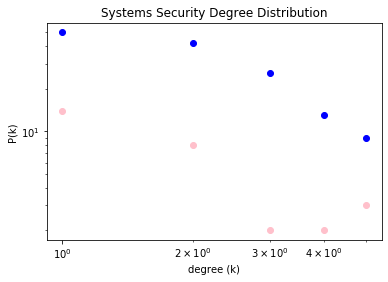

In [194]:
%%time
#for ss graph degree dist

ss_female_graph_nodes = {}
ss_male_graph_nodes = {}
for d in ss.degree():
    if (str(ss.nodes[d[0]]['gender']) == "female"):
        ss_female_graph_nodes[d[0]] = int(d[1])
    else:
        ss_male_graph_nodes[d[0]] = int(d[1])
        
k1, pk1 = zip(*c.Counter(ss_female_graph_nodes.values()).items())
k2, pk2 = zip(*c.Counter(ss_male_graph_nodes.values()).items())

plt.figure(4)
plt.loglog(k1,pk1, marker = "o", linewidth = 0, color ="pink")
plt.loglog(k2,pk2, marker = "o", linewidth = 0, color ="blue")
plt.title("Systems Security Degree Distribution")
plt.xlabel("degree (k)")
plt.ylabel("P(k)")

In [195]:
%%time

#percent x degree ml 


degree_sequence = sorted([d for n, d in ml.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)
coord = []
print(dmax)
num = ml.number_of_nodes()
print(num)

for x in range(dmax):
    y = 0
    for i in ml_female_graph_nodes:
        if (ml_female_graph_nodes[i] >= x):
            y = y + 1
    y = y/num * 100
    coord.append([x,y])
    
coord1 = []
for x1 in range(dmax):
    y1 = 0
    for i in ml_male_graph_nodes:
        if (ml_male_graph_nodes[i] >= x1):
            y1 = y1 + 1
    y1 = y1/num * 100
    coord1.append([x1,y1])

269
194299
CPU times: user 13 s, sys: 1.44 s, total: 14.5 s
Wall time: 14.7 s


Text(0, 0.5, 'Percent')

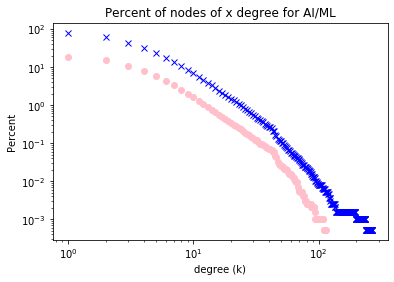

In [196]:
#graph for ml x degree
plt.figure(5)
x1 = [x[0] for x in coord]
y1 = [x[1] for x in coord]
x2 = [x1[0] for x1 in coord1]
y2 = [x1[1] for x1 in coord1]
plt.loglog(x1,y1, marker = "o", linewidth = 0, color ="pink")
plt.loglog(x2,y2, marker = "x", linewidth = 0, color ="blue")
plt.title("Percent of nodes of x degree for AI/ML")
plt.xlabel("degree (k)")
plt.ylabel("Percent")

In [197]:
%%time

#percent x degree ss 


degree_sequence = sorted([d for n, d in ss.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)
coord = []
print(dmax)
num = ss.number_of_nodes()
print(num)

for x in range(dmax):
    y = 0
    for i in ss_female_graph_nodes:
        if (ss_female_graph_nodes[i] >= x):
            y = y + 1
    y = y/num * 100
    coord.append([x,y])
    
coord1 = []
for x1 in range(dmax):
    y1 = 0
    for i in ss_male_graph_nodes:
        if (ss_male_graph_nodes[i] >= x1):
            y1 = y1 + 1
    y1 = y1/num * 100
    coord1.append([x1,y1])

5
179
CPU times: user 1.35 ms, sys: 1.53 ms, total: 2.88 ms
Wall time: 2.69 ms


Text(0, 0.5, 'Percent')

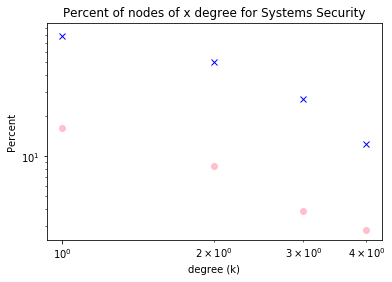

In [198]:
#graph for ss x degree
plt.figure(6)
x1 = [x[0] for x in coord]
y1 = [x[1] for x in coord]
x2 = [x1[0] for x1 in coord1]
y2 = [x1[1] for x1 in coord1]
plt.loglog(x1,y1, marker = "o", linewidth = 0, color ="pink")
plt.loglog(x2,y2, marker = "x", linewidth = 0, color ="blue")
plt.title("Percent of nodes of x degree for Systems Security")
plt.xlabel("degree (k)")
plt.ylabel("Percent")